#### Name:        Mykola Zelenku
#### Mr.Num.:     11734881
#### Date: 24/09/2020

## Description
The aim is to predict the biological activity or toxicity of a drug or a molecule purely based on its chemical structure. You are given a dataset of molecules together with activities and you should train a machine learning model to predict the activities of new molecules based on the selected model.



### Files contained:

- smiles_train.csv: Chemical structures in the training set coded as SMILES strings.
- y_train.csv: Labels for the training set. 1=active, 0=inactive, -1=unknown.
- smiles_test.csv: Chemical structures in the test set (for public + private leaderboard) coded as SMILES strings.
- sample_submission.csv: The format in which the predictions should be submitted.

In [1]:
import pandas as pd
import numpy as np
import csv

import rdkit
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem, Draw, DataStructs
from rdkit.Chem import inchi
from rdkit import RDLogger        # RDLogger in needed to avoid the warnings and error appearing during molecular description
RDLogger.DisableLog('rdApp.*')

The needed data are stored in followed files:

In [2]:
smiles_train = pd.read_csv('./Data/smiles_train.csv')
y_train = pd.read_csv('./Data/y_train.csv')
smiles_test = pd.read_csv('./Data/smiles_test.csv')
sample_submission = pd.read_csv('./Data/sample_submission.csv')

Here I started to explore files containments.

In [3]:
smiles_train

,Smiles
0,O=C(Nc1ccccc1F)c1csc([N+](=O)[O-])c1
1,C[C@H]([C@H]1C[C@]1(C)[C@H](NC(=O)OCc2ccccc2)c...
2,C[C@H]([C@@H]1C[C@@]1(C)[C@@H](NC(=O)OCc2ccccc...
3,COc1ccc(CO\N=C\c2c(C)nc(O)nc2O)cc1
4,CCN1CCC[C@H]1CNC(=O)c2c(O)c(CC)cc(Cl)c2OC
...,...
18151,CCc1nn(C)c(C(=O)NCc2ccc(C(C)(C)C)cc2)c1Cl
18152,Nc1cccnc1N
18153,CN(C)c1ccc(O)c2c1CC1CC3C(N(C)C)C(=O)C(C(N)=O)=...
18154,CN(C)[C@@H]1[C@@H]2C[C@@H]3Cc4c(ccc(O)c4C(=O)C...


In [4]:
smiles_test

,Smiles
0,OC(=O)CCC(=O)c1ccc2ccc3cccc4ccc1c2c34
1,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1
2,Clc1ccc(cc1)n2nnnc2CN3CCOCC3
3,CC1(C)C2(C)CCC1(OC2=O)C(=O)Nc3ncc(s3)[N+](=O)[O-]
4,CCOC(=O)C[C@@H](CC(=O)C)C(=O)OCC
...,...
9465,CCc1c2ccccc2cc2ccc3ccccc3c12
9466,COc1ccc(OC)c(c1)C2CC3=C(C(CC(=O)N3)c4ccc(O)c(O...
9467,CC[C@H](N1C(=O)N2CC[C@H]3[C@H]([C@H](O)[C@H]4O...
9468,CC(C)CC(CCN(C(C)C)C(C)C)(C(N)=O)c1ccccn1


In [5]:
y_train

,Task1,Task2,Task3,Task4,Task5,Task6,Task7,Task8,Task9
0,-1,-1,-1,-1,1,-1,-1,-1,1
1,-1,-1,1,1,-1,-1,-1,-1,-1
2,-1,-1,1,1,-1,-1,-1,-1,-1
3,-1,-1,0,0,-1,-1,-1,-1,-1
4,-1,-1,0,0,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...
18151,-1,-1,-1,-1,-1,-1,-1,1,-1
18152,-1,0,-1,-1,-1,-1,-1,-1,-1
18153,-1,-1,-1,-1,-1,-1,1,1,-1
18154,-1,-1,0,0,-1,-1,-1,-1,-1


In [6]:
y_train['Task1']

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
18151   -1
18152   -1
18153   -1
18154   -1
18155   -1
Name: Task1, Length: 18156, dtype: int64

Read the training data 'Smiles'

In [7]:
training_data = smiles_train['Smiles']

In [8]:
training_data

0                     O=C(Nc1ccccc1F)c1csc([N+](=O)[O-])c1
1        C[C@H]([C@H]1C[C@]1(C)[C@H](NC(=O)OCc2ccccc2)c...
2        C[C@H]([C@@H]1C[C@@]1(C)[C@@H](NC(=O)OCc2ccccc...
3                       COc1ccc(CO\N=C\c2c(C)nc(O)nc2O)cc1
4                CCN1CCC[C@H]1CNC(=O)c2c(O)c(CC)cc(Cl)c2OC
                               ...                        
18151            CCc1nn(C)c(C(=O)NCc2ccc(C(C)(C)C)cc2)c1Cl
18152                                           Nc1cccnc1N
18153    CN(C)c1ccc(O)c2c1CC1CC3C(N(C)C)C(=O)C(C(N)=O)=...
18154    CN(C)[C@@H]1[C@@H]2C[C@@H]3Cc4c(ccc(O)c4C(=O)C...
18155    c1cc(O)c2C(=O)C3=C(O)C4(O)C(=O)C(C(=O)N)=C(O)C...
Name: Smiles, Length: 18156, dtype: object

List of smile's symbols which appeares in smiles strings. I will use it in vectors formation.

In [9]:
conu = []
for i in training_data:
    for j in i:
        if j not in conu:
            conu.extend(j)
conu.sort()
print(conu)

['#', '%', '(', ')', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '@', 'A', 'B', 'C', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'Z', '[', '\\', ']', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'l', 'n', 'o', 'r', 's', 't', 'u']


The followed function 'colect_data()' would be the first molecular description which makes a vector of (1,140) based on molecular properties of given smiles and symbols which appear in Smiles strings.

In [10]:
def colect_data(mol):
    vector = []
    for i in conu:
        vector.append(mol.count(i))
    vector.append(rdkit.Chem.Fragments.fr_Al_COO(Chem.MolFromSmiles(mol), countUnique=True))                  # Number of aliphatic carboxylic acids
    vector.append(rdkit.Chem.Fragments.fr_Al_OH(Chem.MolFromSmiles(mol), countUnique=True))                   # Number of aliphatic hydroxyl groups
    vector.append(rdkit.Chem.Fragments.fr_Al_OH_noTert(Chem.MolFromSmiles(mol), countUnique=True))            # Number of aliphatic hydroxyl groups excluding tert-OH
    vector.append(rdkit.Chem.Fragments.fr_ArN(Chem.MolFromSmiles(mol), countUnique=True))                     # Number of N functional groups attached to aromatics
    vector.append(rdkit.Chem.Fragments.fr_Ar_COO(Chem.MolFromSmiles(mol), countUnique=True))                  # Number of Aromatic carboxylic acide
    vector.append(rdkit.Chem.Fragments.fr_Ar_N(Chem.MolFromSmiles(mol), countUnique=True))                    # Number of aromatic nitrogens
    vector.append(rdkit.Chem.Fragments.fr_Ar_NH(Chem.MolFromSmiles(mol), countUnique=True))                   # Number of aromatic amines
    vector.append(rdkit.Chem.Fragments.fr_Ar_OH(Chem.MolFromSmiles(mol), countUnique=True))                   # Number of aromatic hydroxyl groups
    vector.append(rdkit.Chem.Fragments.fr_COO(Chem.MolFromSmiles(mol), countUnique=True))                     # Number of carboxylic acids
    vector.append(rdkit.Chem.Fragments.fr_COO2(Chem.MolFromSmiles(mol), countUnique=True))                    # Number of carboxylic acids
    vector.append(rdkit.Chem.Fragments.fr_C_O(Chem.MolFromSmiles(mol), countUnique=True))                     # Number of carbonyl O
    vector.append(rdkit.Chem.Fragments.fr_C_O_noCOO(Chem.MolFromSmiles(mol), countUnique=True))               # Number of carbonyl O, excluding COOH
    vector.append(rdkit.Chem.Fragments.fr_C_S(Chem.MolFromSmiles(mol), countUnique=True))                     # Number of thiocarbonyl
    vector.append(rdkit.Chem.Fragments.fr_HOCCN(Chem.MolFromSmiles(mol), countUnique=True))                   # Number of C(OH)CCN-Ctert-alkyl or C(OH)CCNcyclic
    vector.append(rdkit.Chem.Fragments.fr_Imine(Chem.MolFromSmiles(mol), countUnique=True))                   # Number of Imines
    vector.append(rdkit.Chem.Fragments.fr_NH0(Chem.MolFromSmiles(mol), countUnique=True))                     # Number of Tertiary amines
    vector.append(rdkit.Chem.Fragments.fr_NH1(Chem.MolFromSmiles(mol), countUnique=True))                     # Number of Secondary amines
    vector.append(rdkit.Chem.Fragments.fr_NH2(Chem.MolFromSmiles(mol), countUnique=True))                     # Number of Primary amines
    vector.append(rdkit.Chem.Fragments.fr_N_O(Chem.MolFromSmiles(mol), countUnique=True))                     # Number of hydroxylamine groups
    vector.append(rdkit.Chem.Fragments.fr_Ndealkylation1(Chem.MolFromSmiles(mol), countUnique=True))          # Number of XCCNR groups
    vector.append(rdkit.Chem.Fragments.fr_Ndealkylation2(Chem.MolFromSmiles(mol), countUnique=True))          # Number of tert-alicyclic amines (no heteroatoms, not quinine-like bridged N)
    vector.append(rdkit.Chem.Fragments.fr_Nhpyrrole(Chem.MolFromSmiles(mol), countUnique=True))               # Number of H-pyrrole nitrogens
    vector.append(rdkit.Chem.Fragments.fr_SH(Chem.MolFromSmiles(mol), countUnique=True))                      # Number of thiol groups
    vector.append(rdkit.Chem.Fragments.fr_aldehyde(Chem.MolFromSmiles(mol), countUnique=True))                # Number of aldehydes
    vector.append(rdkit.Chem.Fragments.fr_alkyl_carbamate(Chem.MolFromSmiles(mol), countUnique=True))         # Number of alkyl carbamates (subject to hydrolysis)
    vector.append(rdkit.Chem.Fragments.fr_alkyl_halide(Chem.MolFromSmiles(mol), countUnique=True))            # Number of alkyl halides
    vector.append(rdkit.Chem.Fragments.fr_allylic_oxid(Chem.MolFromSmiles(mol), countUnique=True))            # Number of allylic oxidation sites excluding steroid dienone
    vector.append(rdkit.Chem.Fragments.fr_amide(Chem.MolFromSmiles(mol), countUnique=True))                   # Number of amides
    vector.append(rdkit.Chem.Fragments.fr_amidine(Chem.MolFromSmiles(mol), countUnique=True))                 # Number of amidine groups
    vector.append(rdkit.Chem.Fragments.fr_aniline(Chem.MolFromSmiles(mol), countUnique=True))                 # Number of anilines
    vector.append(rdkit.Chem.Fragments.fr_aryl_methyl(Chem.MolFromSmiles(mol), countUnique=True))             # Number of aryl methyl sites for hydroxylation
    vector.append(rdkit.Chem.Fragments.fr_azide(Chem.MolFromSmiles(mol), countUnique=True))                   # Number of azide groups
    vector.append(rdkit.Chem.Fragments.fr_azo(Chem.MolFromSmiles(mol), countUnique=True))                     # Number of azo groups
    vector.append(rdkit.Chem.Fragments.fr_barbitur(Chem.MolFromSmiles(mol), countUnique=True))                # Number of barbiturate groups
    vector.append(rdkit.Chem.Fragments.fr_benzene(Chem.MolFromSmiles(mol), countUnique=True))                 # Number of benzene rings
    vector.append(rdkit.Chem.Fragments.fr_benzodiazepine(Chem.MolFromSmiles(mol), countUnique=True))          # Number of benzodiazepines with no additional fused rings
    vector.append(rdkit.Chem.Fragments.fr_bicyclic(Chem.MolFromSmiles(mol), countUnique=True))                # Bicyclic
    vector.append(rdkit.Chem.Fragments.fr_diazo(Chem.MolFromSmiles(mol), countUnique=True))                   # Number of diazo groups
    vector.append(rdkit.Chem.Fragments.fr_dihydropyridine(Chem.MolFromSmiles(mol), countUnique=True))         # Number of dihydropyridines
    vector.append(rdkit.Chem.Fragments.fr_epoxide(Chem.MolFromSmiles(mol), countUnique=True))                 # Number of epoxide rings
    vector.append(rdkit.Chem.Fragments.fr_ester(Chem.MolFromSmiles(mol), countUnique=True))                   # Number of esters
    vector.append(rdkit.Chem.Fragments.fr_ether(Chem.MolFromSmiles(mol), countUnique=True))                   # Number of ether oxygens (including phenoxy)
    vector.append(rdkit.Chem.Fragments.fr_furan(Chem.MolFromSmiles(mol), countUnique=True))                   # Number of furan rings
    vector.append(rdkit.Chem.Fragments.fr_guanido(Chem.MolFromSmiles(mol), countUnique=True))                 # Number of guanidine groups
    vector.append(rdkit.Chem.Fragments.fr_halogen(Chem.MolFromSmiles(mol), countUnique=True))                 # Number of halogens
    vector.append(rdkit.Chem.Fragments.fr_hdrzine(Chem.MolFromSmiles(mol), countUnique=True))                 # Number of hydrazine groups
    vector.append(rdkit.Chem.Fragments.fr_hdrzone(Chem.MolFromSmiles(mol), countUnique=True))                 # Number of hydrazone groups
    vector.append(rdkit.Chem.Fragments.fr_imidazole(Chem.MolFromSmiles(mol), countUnique=True))               # Number of imidazole rings
    vector.append(rdkit.Chem.Fragments.fr_imide(Chem.MolFromSmiles(mol), countUnique=True))                   # Number of imide groups
    vector.append(rdkit.Chem.Fragments.fr_isocyan(Chem.MolFromSmiles(mol), countUnique=True))                 # Number of isocyanates
    vector.append(rdkit.Chem.Fragments.fr_isothiocyan(Chem.MolFromSmiles(mol), countUnique=True))             # Number of isothiocyanates
    vector.append(rdkit.Chem.Fragments.fr_ketone(Chem.MolFromSmiles(mol), countUnique=True))                  # Number of ketones
    vector.append(rdkit.Chem.Fragments.fr_ketone_Topliss(Chem.MolFromSmiles(mol), countUnique=True))          # Number of ketones excluding diaryl, a,b-unsat. dienones, heteroatom on Calpha
    vector.append(rdkit.Chem.Fragments.fr_lactam(Chem.MolFromSmiles(mol), countUnique=True))                  # Number of beta lactams
    vector.append(rdkit.Chem.Fragments.fr_lactone(Chem.MolFromSmiles(mol), countUnique=True))                 # Number of cyclic esters (lactones)
    vector.append(rdkit.Chem.Fragments.fr_methoxy(Chem.MolFromSmiles(mol), countUnique=True))                 # Number of methoxy groups -OCH3
    vector.append(rdkit.Chem.Fragments.fr_morpholine(Chem.MolFromSmiles(mol), countUnique=True))              # Number of morpholine rings
    vector.append(rdkit.Chem.Fragments.fr_nitrile(Chem.MolFromSmiles(mol), countUnique=True))                 # Number of nitriles
    vector.append(rdkit.Chem.Fragments.fr_nitro(Chem.MolFromSmiles(mol), countUnique=True))                   # Number of nitro groups
    vector.append(rdkit.Chem.Fragments.fr_nitro_arom(Chem.MolFromSmiles(mol), countUnique=True))              # Number of nitro benzene ring substituents
    vector.append(rdkit.Chem.Fragments.fr_nitro_arom_nonortho(Chem.MolFromSmiles(mol), countUnique=True))     # Number of non-ortho nitro benzene ring substituents
    vector.append(rdkit.Chem.Fragments.fr_nitroso(Chem.MolFromSmiles(mol), countUnique=True))                 # Number of nitroso groups, excluding NO2
    vector.append(rdkit.Chem.Fragments.fr_oxazole(Chem.MolFromSmiles(mol), countUnique=True))                 # Number of oxazole rings
    vector.append(rdkit.Chem.Fragments.fr_oxime(Chem.MolFromSmiles(mol), countUnique=True))                   # Number of oxime groups
    vector.append(rdkit.Chem.Fragments.fr_para_hydroxylation(Chem.MolFromSmiles(mol), countUnique=True))      # Number of para-hydroxylation sites
    vector.append(rdkit.Chem.Fragments.fr_phenol(Chem.MolFromSmiles(mol), countUnique=True))                  # Number of phenols
    vector.append(rdkit.Chem.Fragments.fr_phenol_noOrthoHbond(Chem.MolFromSmiles(mol), countUnique=True))     # Number of phenolic OH excluding ortho intraChem.MolFromSmiles(mol)ecular Hbond substituents
    vector.append(rdkit.Chem.Fragments.fr_phos_acid(Chem.MolFromSmiles(mol), countUnique=True))               # Number of phosphoric acid groups
    vector.append(rdkit.Chem.Fragments.fr_phos_ester(Chem.MolFromSmiles(mol), countUnique=True))              # Number of phosphoric ester groups
    vector.append(rdkit.Chem.Fragments.fr_piperdine(Chem.MolFromSmiles(mol), countUnique=True))               # Number of piperdine rings
    vector.append(rdkit.Chem.Fragments.fr_piperzine(Chem.MolFromSmiles(mol), countUnique=True))               # Number of piperzine rings
    vector.append(rdkit.Chem.Fragments.fr_priamide(Chem.MolFromSmiles(mol), countUnique=True))                # Number of primary amides
    vector.append(rdkit.Chem.Fragments.fr_prisulfonamd(Chem.MolFromSmiles(mol), countUnique=True))            # Number of primary sulfonamides
    vector.append(rdkit.Chem.Fragments.fr_pyridine(Chem.MolFromSmiles(mol), countUnique=True))                # Number of pyridine rings
    vector.append(rdkit.Chem.Fragments.fr_quatN(Chem.MolFromSmiles(mol), countUnique=True))                   # Number of quarternary nitrogens
    vector.append(rdkit.Chem.Fragments.fr_sulfide(Chem.MolFromSmiles(mol), countUnique=True))                 # Number of thioether
    vector.append(rdkit.Chem.Fragments.fr_sulfonamd(Chem.MolFromSmiles(mol), countUnique=True))               # Number of sulfonamides
    vector.append(rdkit.Chem.Fragments.fr_sulfone(Chem.MolFromSmiles(mol), countUnique=True))                 # Number of sulfone groups
    vector.append(rdkit.Chem.Fragments.fr_term_acetylene(Chem.MolFromSmiles(mol), countUnique=True))          # Number of terminal acetylenes
    vector.append(rdkit.Chem.Fragments.fr_tetrazole(Chem.MolFromSmiles(mol), countUnique=True))               # Number of tetrazole rings
    vector.append(rdkit.Chem.Fragments.fr_thiazole(Chem.MolFromSmiles(mol), countUnique=True))                # Number of thiazole rings
    vector.append(rdkit.Chem.Fragments.fr_thiocyan(Chem.MolFromSmiles(mol), countUnique=True))                # Number of thiocyanates
    vector.append(rdkit.Chem.Fragments.fr_thiophene(Chem.MolFromSmiles(mol), countUnique=True))               # Number of thiophene rings
    vector.append(rdkit.Chem.Fragments.fr_unbrch_alkane(Chem.MolFromSmiles(mol), countUnique=True))           # Number of unbranched alkanes of at least 4 members (excludes halogenated alkanes)
    vector.append(rdkit.Chem.Fragments.fr_urea(Chem.MolFromSmiles(mol), countUnique=True))                    # Number of urea groups

    return np.asarray(vector)

*Extended-Connectivity Fingerprints (ECFPs)* are circular topological fingerprints designed for molecular characterization, similarity searching, and structure-activity modeling. They are among the most popular similarity search tools in drug discovery and they are effectively used in a wide variety of applications.
Followed function buidls an additional vector to molecular description. It has 2 tuned parameters *fingerprint length (FPL)*  and *fingerprint radius (FPR)*. The common parameters are 1024 for *FPL* and 3 or 4 for *FPR* 

*more details at:*
**https://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints**

In [11]:
def get_fingerprint(smiles, hyp_fingerprint_length=4096, hyp_fingerprint_radius=3):
    """Get Morgan Fingerprint of a specific SMILES string.

      Args:
        smiles: String. The SMILES string of the molecule.
        hparams: tf.contrib.training.HParams. Hyper parameters.

      Returns:
        np.array. shape = [hparams.fingerprint_length]. The Morgan fingerprint.
      """
    if smiles is None:
        return np.zeros((hyp_fingerprint_length,))
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return np.zeros((hyp_fingerprint_length,))
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, hyp_fingerprint_radius, hyp_fingerprint_length)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fingerprint, arr)
    return arr 

#### Some statistics what could help to choose the right tuned parameters
For *FPR* from 1 to 16 with a step of 1 and for *FPL* from 32 bits to 16384 bits with a step of 32 bits for the largest smile string was applied *FP* function. By this statistic the next things were obserwed:
- after some amount of bits the amount of 1 in vector does not increased; (~2048 bits)
- increasing of radius would always lead to a vector with a higher amount of 1 in it;   

Finding the longest string

In [12]:
max_len = 0
index = 0
for i, mol in enumerate(training_data):
    if len(mol) > max_len:
        max_len = len(mol)
        index = i

print(index, max_len)
 

15082 616


Statistics for fingerprint:
- radius from 1 to 16
- bits from 32 to 16384

In [13]:
radius = list(range(1,17))
bits = list(range(32,2*8192+32,32))

Some researchers are recommended to start from 1024 bits but also check higher numbers and see of losing too much information.
I started from 32 to 16384 bits and radius from 1 to 16.

https://www.researchgate.net/post/How_to_choose_bits_and_radius_during_circular_fingerprint_calculation_in_RDKit

In [14]:
csv_stat_fp = './report/stat_fp.csv'
with open(csv_stat_fp, mode='w') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for r in radius:
        z_r = [r,]
        z_b = [r,]
        for b in bits:
            a = get_fingerprint(training_data[15082], hyp_fingerprint_length=b, hyp_fingerprint_radius=r)
            print('radius = %.2s\t|  bits = %.5s\t| amount of 1 = %.4s\t| 1/bits = %.6s' % (r, b, np.count_nonzero(a == 1), (np.count_nonzero(a == 1)/b)))
            z_r.append(np.count_nonzero(a == 1)/b)
            z_b.append(b)
        csv_writer.writerow(z_r)
        csv_writer.writerow(z_b)

radius = 1	|  bits = 32	| amount of 1 = 30	| 1/bits = 0.9375
radius = 1	|  bits = 64	| amount of 1 = 46	| 1/bits = 0.7187
radius = 1	|  bits = 96	| amount of 1 = 56	| 1/bits = 0.5833
radius = 1	|  bits = 128	| amount of 1 = 57	| 1/bits = 0.4453
radius = 1	|  bits = 160	| amount of 1 = 62	| 1/bits = 0.3875
radius = 1	|  bits = 192	| amount of 1 = 62	| 1/bits = 0.3229
radius = 1	|  bits = 224	| amount of 1 = 64	| 1/bits = 0.2857
radius = 1	|  bits = 256	| amount of 1 = 63	| 1/bits = 0.2460
radius = 1	|  bits = 288	| amount of 1 = 67	| 1/bits = 0.2326
radius = 1	|  bits = 320	| amount of 1 = 66	| 1/bits = 0.2062
radius = 1	|  bits = 352	| amount of 1 = 66	| 1/bits = 0.1875
radius = 1	|  bits = 384	| amount of 1 = 67	| 1/bits = 0.1744
radius = 1	|  bits = 416	| amount of 1 = 68	| 1/bits = 0.1634
radius = 1	|  bits = 448	| amount of 1 = 67	| 1/bits = 0.1495
radius = 1	|  bits = 480	| amount of 1 = 67	| 1/bits = 0.1395
radius = 1	|  bits = 512	| amount of 1 = 65	| 1/bits = 0.1269
radius = 1	

[SiH4]


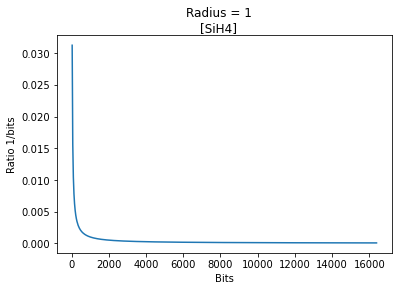

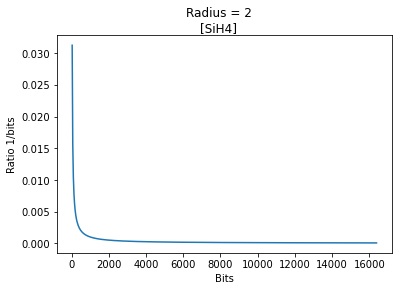

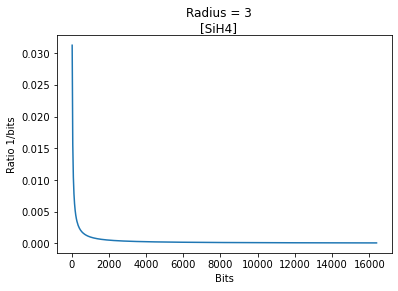

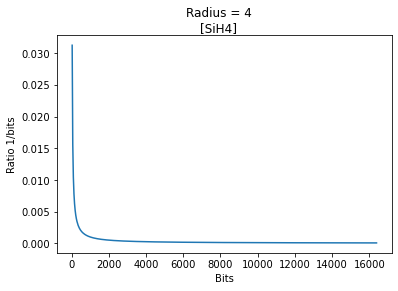

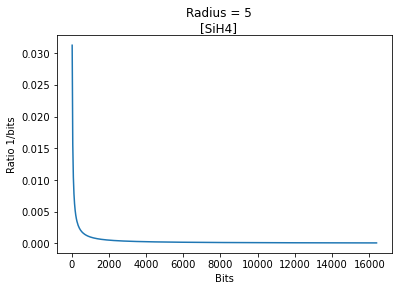

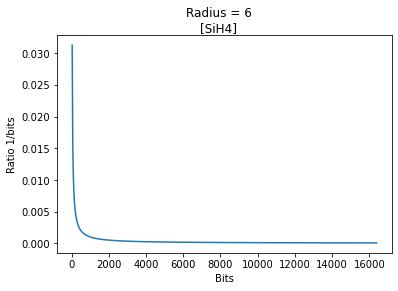

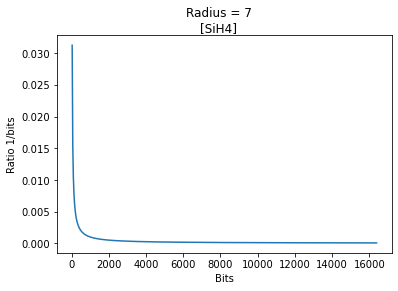

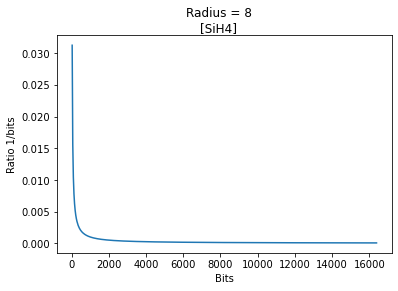

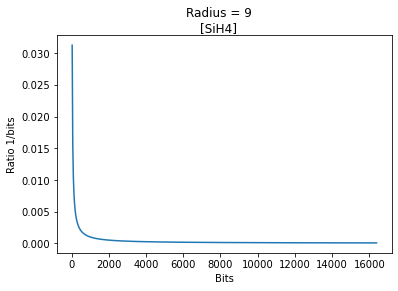

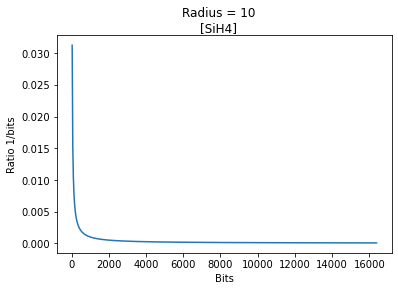

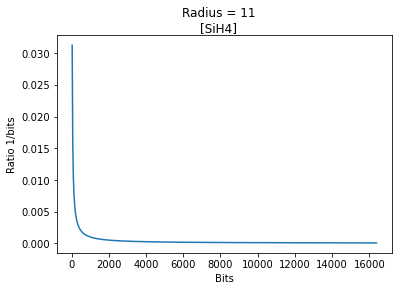

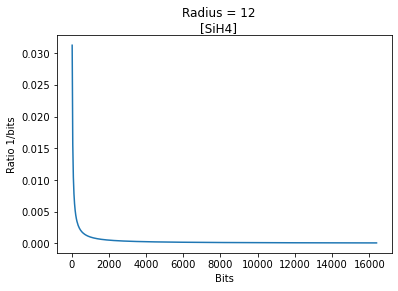

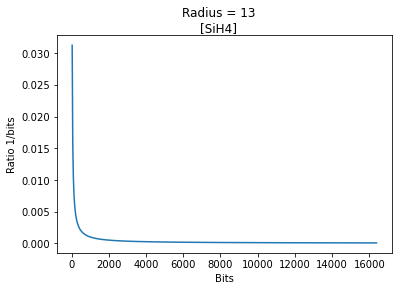

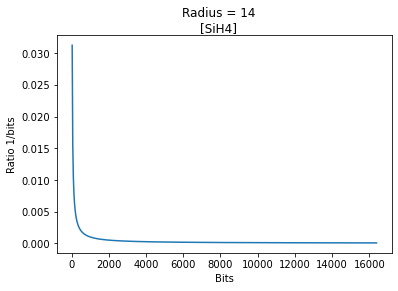

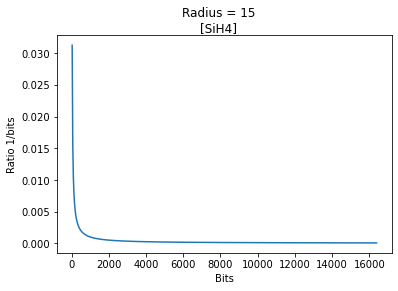

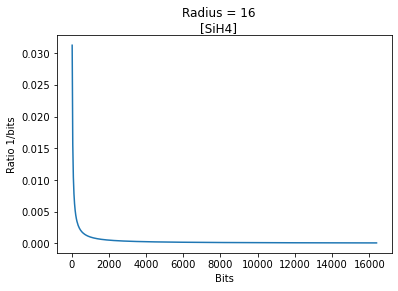

In [15]:
from matplotlib import pyplot as plt

csv_stat_fp_1059 = './report/stat_fp_1059.csv'
print(training_data[1059])
with open(csv_stat_fp_1059, mode='w') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for r in radius:
        z_r = []
        z_b = []
        for b in bits:
            a = get_fingerprint(training_data[1059], hyp_fingerprint_length=b, hyp_fingerprint_radius=r)
#             print('radius = %.2s\t|  bits = %.5s\t| amount of 1 = %.4s\t| 1/bits = %.6s' % (r, b, np.count_nonzero(a == 1), (np.count_nonzero(a == 1)/b)))
            z_r.append(np.count_nonzero(a == 1)/b)
            z_b.append(b)
        csv_writer.writerow(z_r)
        csv_writer.writerow(z_b)
        plt.plot(z_b, z_r)
        plt.ylabel('Ratio 1/bits')
        plt.xlabel('Bits')
        plt.suptitle('Radius = %s\n%s' % (r, training_data[1059]))
        plt.show()

CCC(C)C(NC(=O)C(NC(=O)C(CCC(=O)O)NC(=O)C(CC(C)C)NC(=O)C(CCSC)NC(=O)C(CCCCN)NC(=O)C(CCCNC(=N)N)NC(=O)C(CC(N)=O)NC(=O)C(CO)NC(=O)C(Cc1cnc[nH]1)NC(=O)C(C)NC(=O)C(CCC(N)=O)NC(=O)C(CCC(N)=O)NC(=O)C(C)NC(=O)C(CC(C)C)NC(=O)C(CCC(N)=O)NC(=O)C(CCC(=O)O)NC(=O)C(C)NC(=O)C(CCCNC(=N)N)NC(=O)C(C)NC(=O)C(CCSC)NC(=O)C(CCC(=O)O)NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(CCC(=O)O)NC(=O)C(CCCNC(=N)N)NC(=O)C(CC(C)C)NC(=O)C(CC(C)C)NC(=O)C(Cc1cnc[nH]1)NC(=O)C(Cc1ccccc1)NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(CC(=O)O)NC(=O)C(CC(C)C)NC(=O)C(CO)NC(=O)C(NC(=O)C1CCCN1C(=O)C1CCCN1C(=O)C(CCC(=O)O)NC(=O)C(CCC(=O)O)NC(=O)C(N)CO)C(C)CC)C(C)O)C(C)C)C(C)CC)C(=O)O


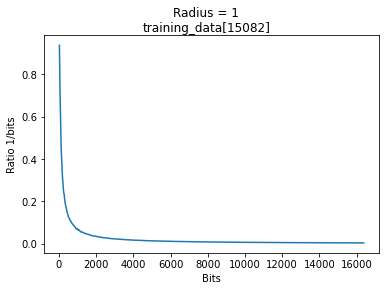

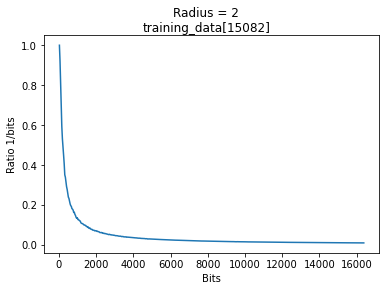

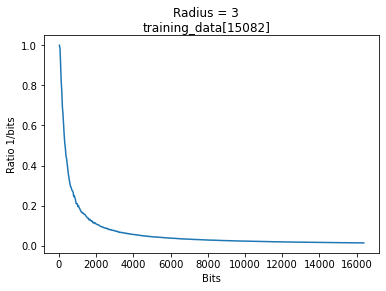

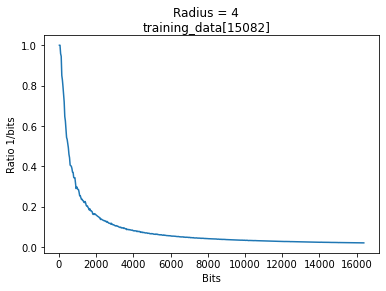

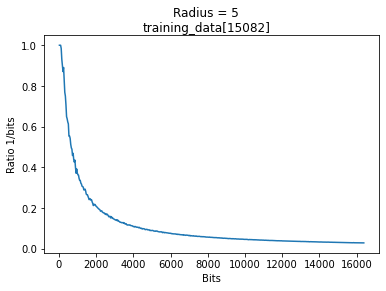

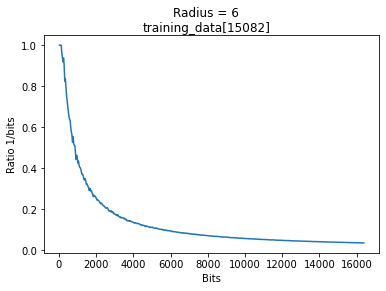

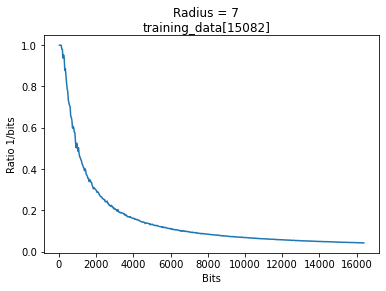

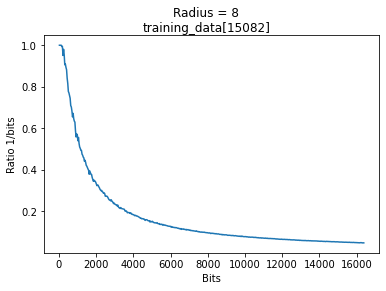

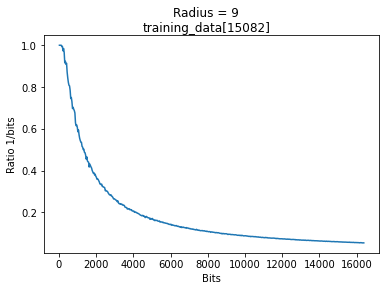

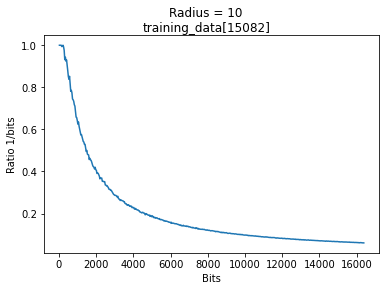

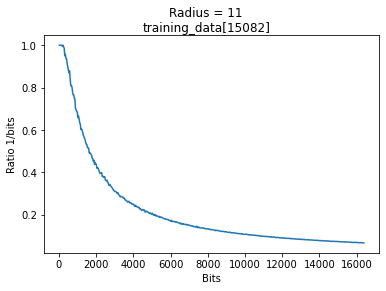

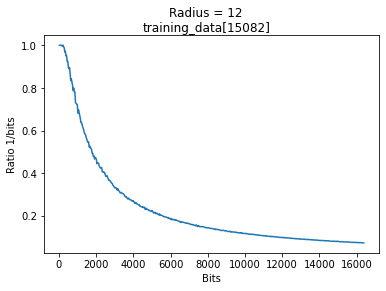

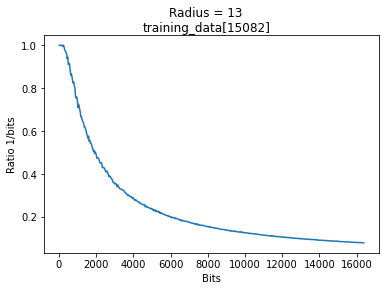

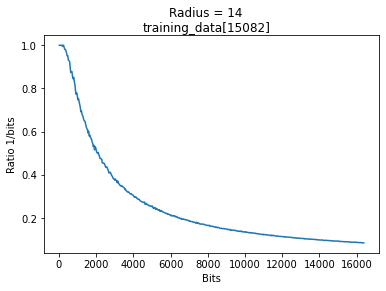

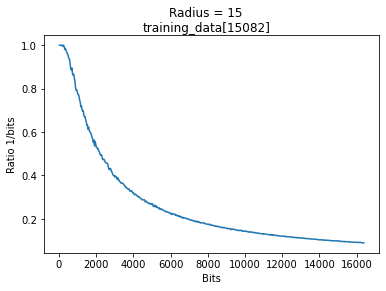

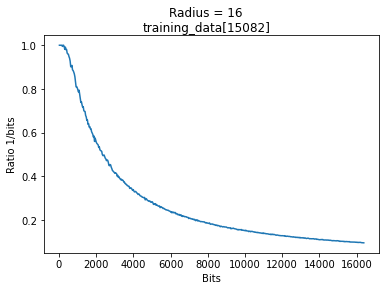

In [16]:
csv_stat_fp_15082 = './report/stat_fp_15082.csv'
print(training_data[15082])
with open(csv_stat_fp_15082, mode='w') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for r in radius:
        z_r = []
        z_b = []
        for b in bits:
            a = get_fingerprint(training_data[15082], hyp_fingerprint_length=b, hyp_fingerprint_radius=r)
#             print('radius = %.2s\t|  bits = %.5s\t| amount of 1 = %.4s\t| 1/bits = %.6s' % (r, b, np.count_nonzero(a == 1), (np.count_nonzero(a == 1)/b)))
            z_r.append(np.count_nonzero(a == 1)/b)
            z_b.append(b)
        csv_writer.writerow(z_r)
        csv_writer.writerow(z_b)
        plt.plot(z_b, z_r)
        plt.ylabel('Ratio 1/bits')
        plt.xlabel('Bits')
        plt.suptitle('Radius = %s\n%s' % (r, 'training_data[15082]'))
        plt.show()

Some statistics for smallest and largest 'smiles' string for radius 3 and 4, for bits from 1600 to 2400.
Here could be observed that for the smallest molecule in dataset at give range of radius and bits the '1' in each vectors presents only once. That means that for this amount of bits is higher then needed for molecular vector.
With bits increasing the ratio of '1/bits' would decreased and would increase the vector length that leads to more computation resources.

In [17]:
sm, lg = 1059, 15082
vec = [sm, lg]
data_mol = [training_data[sm], training_data[lg]]
radius = list(range(3,5))
bits = list(range(1600,2400+32,32))
for k, dat in enumerate(data_mol):
    for r in radius:
        highest, b_i, rt = 0, 0, 0 
        for b in bits:
            a = get_fingerprint(dat, hyp_fingerprint_length=b, hyp_fingerprint_radius=r)
            am_1 = np.count_nonzero(a == 1)
            rt_1 = np.count_nonzero(a == 1)/b
            if highest < am_1:
                highest, rt, b_i = am_1, rt_1, b 
            text = 'radius = %.2s | bits = %.5s | amount of 1 = %.4s | 1/bits = %.6s | [highest = %.4s, bits = %.5s, ration = %.6s] | %s' % (r, b, am_1, rt_1, highest, b_i, rt, vec[k])
            print(text)
        print(len(text) * '=')

radius = 3 | bits = 1600 | amount of 1 = 1 | 1/bits = 0.0006 | [highest = 1, bits = 1600, ration = 0.0006] | 1059
radius = 3 | bits = 1632 | amount of 1 = 1 | 1/bits = 0.0006 | [highest = 1, bits = 1600, ration = 0.0006] | 1059
radius = 3 | bits = 1664 | amount of 1 = 1 | 1/bits = 0.0006 | [highest = 1, bits = 1600, ration = 0.0006] | 1059
radius = 3 | bits = 1696 | amount of 1 = 1 | 1/bits = 0.0005 | [highest = 1, bits = 1600, ration = 0.0006] | 1059
radius = 3 | bits = 1728 | amount of 1 = 1 | 1/bits = 0.0005 | [highest = 1, bits = 1600, ration = 0.0006] | 1059
radius = 3 | bits = 1760 | amount of 1 = 1 | 1/bits = 0.0005 | [highest = 1, bits = 1600, ration = 0.0006] | 1059
radius = 3 | bits = 1792 | amount of 1 = 1 | 1/bits = 0.0005 | [highest = 1, bits = 1600, ration = 0.0006] | 1059
radius = 3 | bits = 1824 | amount of 1 = 1 | 1/bits = 0.0005 | [highest = 1, bits = 1600, ration = 0.0006] | 1059
radius = 3 | bits = 1856 | amount of 1 = 1 | 1/bits = 0.0005 | [highest = 1, bits = 1600

In [18]:
radius = list(range(2,6))
radius = [4]
bits = list(range(1024,8192+1024,1024))
rate = [1, 0, 0, 0]
for i, mol in enumerate(training_data):
    for r in radius:
        for b in bits:
            a = get_fingerprint(mol, hyp_fingerprint_length=b, hyp_fingerprint_radius=r)
            rate_cycle = np.count_nonzero(a == 1)/b
            if rate_cycle < rate[0]:
                rate = [rate_cycle, b, r, i]

print('The lowest 1/bits ratio is %s \nin %s bits \nwith a radius of %s \nin dataset at %s position which is the followed smile:\n%s' 
      % (rate[0], rate[1], rate[2], rate[3], training_data[rate[3]]))

The lowest 1/bits ratio is 0.0001220703125 
in 8192 bits 
with a radius of 4 
in dataset at 1059 position which is the followed smile:
[SiH4]


Concatenation of two descriptive vectors. I used it because, maybe, for some tasks would be better to use only one of them (fingerprint or characteristic description) or both for more vector's parameters. 

- 1st type - fingerprint only
- 2nd type - fingerprint + characteristics
- 3rd type - characteristics

In [19]:
def conc_2_arrays(mol, vector_type=1):
    if vector_type==1:
        return np.concatenate([get_fingerprint(mol, hyp_fingerprint_length=1024*2, hyp_fingerprint_radius=4), colect_data(mol)])
    elif vector_type==2:
        return get_fingerprint(mol, hyp_fingerprint_length=1024*2, hyp_fingerprint_radius=4)
    elif vector_type==3:
        return colect_data(mol)

    
vector_ = conc_2_arrays(training_data[0], vector_type=3)

Example of 3rd type (molecular characteristics)

In [20]:
print(vector_)
print(len(vector_))

[ 0  0  3  3  1  1  0  0  0  4  0  0  0  0  0  0  0  0  2  0  0  0  1  1
  0  0  0  0  0  0  2  3  0  0  0  0  0  2  0  2  0  0 10  0  0  0  0  0
  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  1  1
  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  1  0  0  0  0  0  0
  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
140


Storing of different vectors arrays of preprocessed smiles.

In [21]:
# vector_type=1
# with open('./training_matrice_vt_1.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['f_%s' % (x + 1) for x in range(len(conc_2_arrays(training_data[0], vector_type=vector_type)))])
#     for mol in training_data:
#         writer.writerow([i for i in conc_2_arrays(mol, vector_type=vector_type)])

In [22]:
# vector_type=2
# with open('./training_matrice_vt_2.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['f_%s' % (x + 1) for x in range(len(conc_2_arrays(training_data[0], vector_type=vector_type)))])
#     for mol in training_data:
#         writer.writerow([i for i in conc_2_arrays(mol, vector_type=vector_type)])

In [23]:
# vector_type=3
# with open('./training_matrice_vt_3.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['f_%s' % (x + 1) for x in range(len(conc_2_arrays(training_data[0], vector_type=vector_type)))])
#     for mol in training_data:
#         writer.writerow([i for i in conc_2_arrays(mol, vector_type=vector_type)])

Opening again

In [24]:
tr_1 = pd.read_csv('./training_matrice_vt_1.csv')
tr_array_1 = tr_1.values
tr_2 = pd.read_csv('./training_matrice_vt_2.csv')
tr_array_2 = tr_2.values
tr_3 = pd.read_csv('./training_matrice_vt_3.csv')
tr_array_3 = tr_3.values
del tr_1, tr_2, tr_3

Check the shapes

In [25]:
tr_array_1.shape, tr_array_2.shape, tr_array_3.shape

((18156, 2188), (18156, 2048), (18156, 140))

In [26]:
tr_arrays = [tr_array_1, tr_array_2, tr_array_3]

In [27]:
len(tr_arrays)

3

In [28]:
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

Parameters of ANN classifier.

In [29]:
activation = ['identity', 'logistic', 'tanh', 'relu']
alpha = [1e-1, 1e-3, 1e-5]
batch_size = [16, 64, 256, 1024]
early_stopping = [True]
hidden_layer_sizes = [(100,), (500,), (1000,), 
        (100,5), (500,5), (1000,5),
        (100,10), (500,10), (1000,10), 
        (100,50), (500,50), (1000,50),
        (100,100), (500,100), (1000,100)]
learning_rate = ['constant', 'invscaling', 'adaptive']
max_iter = [10, 50, 250]
n_iter_no_change = [5, 10]
nesterovs_momentum = [True, False]
shuffle = [True]
solver = ['adam', 'lbfgs', 'sgd']
tol = [1e-1, 1e-3, 1e-5]

In [30]:
report_name = './report/report.txt'
# report = open(report_name, 'w')

Storing classifier's parameters and confusion matrix of trained nets.

In [31]:
# z = 0
# for inde, tr_array in enumerate(tr_arrays):
#     for i in range(1,10):
#         report.write('Training set #'+str(inde+1))
#         report.write(str(tr_array.shape))
#         report.write('\n')
#         report.write('Task%s' % i)
#         report.write('\n')
#         y_1 = y_train['Task%s' % i]
#         y_1 = y_1.values
#         X_train, X_test, Y_train, Y_test = train_test_split(tr_array, y_1, test_size=0.2, random_state=0)
        
#         print('activation')
#         report.write(str('activation'))
#         report.write(str('\n'))
#         for act in activation:
#             clf_TN = MLPClassifier(activation = act, early_stopping = True, shuffle = False)
#             report.write(str(X_train.shape))
#             report.write(str(X_test.shape))
#             report.write(str(Y_train.shape))
#             report.write(str(Y_test.shape))
#             report.write(str('\n'))
#             report.write(str(clf_TN))
#             report.write(str('\n'))

#             clf_TN.fit(X_train, Y_train)
#             prob = clf_TN.predict(X_test)
#             confusion_matrix(Y_test, prob)
#             report.write(str(classification_report(Y_test, prob)))
#             report.write('\n')

#             z += 1

#             print(z)
            
#         print('alpha')
#         report.write(str('alpha'))
#         report.write(str('\n'))
#         for alf in alpha:
#             clf_TN = MLPClassifier(alpha = alf, early_stopping = True, shuffle = False)
#             report.write(str(X_train.shape))
#             report.write(str(X_test.shape))
#             report.write(str(Y_train.shape))
#             report.write(str(Y_test.shape))
#             report.write(str('\n'))
#             report.write(str(clf_TN))
#             report.write(str('\n'))

#             clf_TN.fit(X_train, Y_train)
#             prob = clf_TN.predict(X_test)
#             confusion_matrix(Y_test, prob)
#             report.write(str(classification_report(Y_test, prob)))
#             report.write('\n\n')

#             z += 1

#             print(z)
        
#         print('batch_size')
#         report.write(str('batch_size'))
#         report.write(str('\n'))
#         for b_s in batch_size:
#             clf_TN = MLPClassifier(batch_size = b_s, early_stopping = True, shuffle = False)
#             report.write(str(X_train.shape))
#             report.write(str(X_test.shape))
#             report.write(str(Y_train.shape))
#             report.write(str(Y_test.shape))
#             report.write(str('\n'))
#             report.write(str(clf_TN))
#             report.write(str('\n'))

#             clf_TN.fit(X_train, Y_train)
#             prob = clf_TN.predict(X_test)
#             confusion_matrix(Y_test, prob)
#             report.write(str(classification_report(Y_test, prob)))
#             report.write('\n')

#             z += 1

#             print(z)
            
#         print('hidden_layer_sizes')
#         report.write(str('hidden_layer_sizes'))
#         report.write(str('\n'))
#         for h_l_s in hidden_layer_sizes:
#             clf_TN = MLPClassifier(hidden_layer_sizes = h_l_s, early_stopping = True, shuffle = False)
#             report.write(str(X_train.shape))
#             report.write(str(X_test.shape))
#             report.write(str(Y_train.shape))
#             report.write(str(Y_test.shape))
#             report.write(str('\n'))
#             report.write(str(clf_TN))
#             report.write(str('\n'))

#             clf_TN.fit(X_train, Y_train)
#             prob = clf_TN.predict(X_test)
#             confusion_matrix(Y_test, prob)
#             report.write(str(classification_report(Y_test, prob)))
#             report.write('\n')

#             z += 1

#             print(z)
            
#         print('learning_rate')
#         report.write(str('learning_rate'))
#         report.write(str('\n'))
#         for lr in learning_rate:
#             clf_TN = MLPClassifier(learning_rate = lr, early_stopping = True, shuffle = False)
#             report.write(str(X_train.shape))
#             report.write(str(X_test.shape))
#             report.write(str(Y_train.shape))
#             report.write(str(Y_test.shape))
#             report.write(str('\n'))
#             report.write(str(clf_TN))
#             report.write(str('\n'))

#             clf_TN.fit(X_train, Y_train)
#             prob = clf_TN.predict(X_test)
#             confusion_matrix(Y_test, prob)
#             report.write(str(classification_report(Y_test, prob)))
#             report.write('\n')

#             z += 1

#             print(z)
            
#         print('max_iter')
#         report.write(str('max_iter'))
#         report.write(str('\n'))
#         for mi in max_iter:
#             clf_TN = MLPClassifier(max_iter = mi, early_stopping = True, shuffle = False)
#             report.write(str(X_train.shape))
#             report.write(str(X_test.shape))
#             report.write(str(Y_train.shape))
#             report.write(str(Y_test.shape))
#             report.write(str('\n'))
#             report.write(str(clf_TN))
#             report.write(str('\n'))

#             clf_TN.fit(X_train, Y_train)
#             prob = clf_TN.predict(X_test)
#             confusion_matrix(Y_test, prob)
#             report.write(str(classification_report(Y_test, prob)))
#             report.write('\n')

#             z += 1

#             print(z)
            
#         print('n_iter_no_change')
#         report.write(str('n_iter_no_change'))
#         report.write(str('\n'))
#         for ni in n_iter_no_change:
#             clf_TN = MLPClassifier(n_iter_no_change = ni, early_stopping = True, shuffle = False)
#             report.write(str(X_train.shape))
#             report.write(str(X_test.shape))
#             report.write(str(Y_train.shape))
#             report.write(str(Y_test.shape))
#             report.write(str('\n'))
#             report.write(str(clf_TN))
#             report.write(str('\n'))

#             clf_TN.fit(X_train, Y_train)
#             prob = clf_TN.predict(X_test)
#             confusion_matrix(Y_test, prob)
#             report.write(str(classification_report(Y_test, prob)))
#             report.write('\n')

#             z += 1

#             print(z)
            
#         print('nesterovs_momentum')
#         report.write(str('nesterovs_momentum'))
#         report.write(str('\n'))
#         for nm in nesterovs_momentum:
#             clf_TN = MLPClassifier(nesterovs_momentum = nm, early_stopping = True, shuffle = False)
#             report.write(str(X_train.shape))
#             report.write(str(X_test.shape))
#             report.write(str(Y_train.shape))
#             report.write(str(Y_test.shape))
#             report.write(str('\n'))
#             report.write(str(clf_TN))
#             report.write(str('\n'))

#             clf_TN.fit(X_train, Y_train)
#             prob = clf_TN.predict(X_test)
#             confusion_matrix(Y_test, prob)
#             report.write(str(classification_report(Y_test, prob)))
#             report.write('\n')

#             z += 1

#             print(z) 
        
#         print('solver')
#         report.write(str('solver'))
#         report.write(str('\n'))
#         for sol in solver:
#             clf_TN = MLPClassifier(solver = sol, early_stopping = True, shuffle = False)
#             report.write(str(X_train.shape))
#             report.write(str(X_test.shape))
#             report.write(str(Y_train.shape))
#             report.write(str(Y_test.shape))
#             report.write(str('\n'))
#             report.write(str(clf_TN))
#             report.write(str('\n'))

#             clf_TN.fit(X_train, Y_train)
#             prob = clf_TN.predict(X_test)
#             confusion_matrix(Y_test, prob)
#             report.write(str(classification_report(Y_test, prob)))
#             report.write('\n')

#             z += 1

#             print(z)
        
#         print('tol')
#         report.write(str('tol'))
#         report.write(str('\n'))
#         for t in tol:
#             clf_TN = MLPClassifier(tol = t, early_stopping = True, shuffle = False)
#             report.write(str(X_train.shape))
#             report.write(str(X_test.shape))
#             report.write(str(Y_train.shape))
#             report.write(str(Y_test.shape))
#             report.write(str('\n'))
#             report.write(str(clf_TN))
#             report.write(str('\n'))

#             clf_TN.fit(X_train, Y_train)
#             prob = clf_TN.predict(X_test)
#             confusion_matrix(Y_test, prob)
#             report.write(str(classification_report(Y_test, prob)))
#             report.write('\n')

#             z += 1

#             print(z)   
        
        
# print('Done...')

In [32]:
# report.close()

Get the main values of each trained net.

In [33]:
check_report = open(report_name, 'r').read().split('Training set ')[1:]

In [34]:
descr_values = ['Training_set', 'Task', 'Mod', 'precision_-1', 
     'precision_0', 'precision_1', 'recall_-1','recall_0', 
     'recall_1', 'f1-score_-1', 'f1-score_0', 'f1-score_1', 'accuracy']

mods_check =['activation', 'alpha', 'batch_size', 'hidden_layer_sizes', 
             'learning_rate', 'max_iter', 'n_iter_no_change', 'nesterovs_momentum', 
             'solver', 'tol'] 

In [35]:
def form_stat_array(array, a, mods_check):    
    array_to_store = []

    for i in range(int(len(array)/3)):
        some_array = []
        if i == 0:
            ts = array[3*i + 0][:2]
            ta = array[3*i + 0].split('\n')[1]
            z = array[3*i + 0].split('\n')[2]
            some_array.append(str(ts))
            some_array.append(str(ta))
            some_array.append(str(z + array[3*i + 0].split(z)[2].split(',')[0]))
            some_array.append(str(float(array[3*i + 1].split('      ')[2])))
            some_array.append(str(float(array[3*i + 1].split('      ')[7])))
            some_array.append(str(float(array[3*i + 1].split('      ')[12])))
            some_array.append(str(float(array[3*i + 1].split('      ')[3])))
            some_array.append(str(float(array[3*i + 1].split('      ')[8])))
            some_array.append(str(float(array[3*i + 1].split('      ')[13])))
            some_array.append(str(float(array[3*i + 1].split('      ')[4])))
            some_array.append(str(float(array[3*i + 1].split('      ')[9])))
            some_array.append(str(float(array[3*i + 1].split('      ')[14])))
            some_array.append(str(float(array[3*i + 2].split('      ')[4])))

        elif i > 0:
            some_array.append(str(ts))
            some_array.append(str(ta))
            if array[3*i + 0].split('\n')[0] in mods_check:
                z = array[3*i + 0].split('\n')[0]
                if z == 'hidden_layer_sizes':
                    some_array.append(str(z + array[3*i + 0].split(z)[2].split(',')[0] + array[3*i + 0].split(z)[2].split(',')[1]))
                else:
                    some_array.append(str(z + array[3*i + 0].split(z)[2].split(',')[0]))
            elif array[3*i + 0].split('\n')[1] in mods_check:
                z = array[3*i + 0].split('\n')[1]
                some_array.append(str(z + array[3*i + 0].split(z)[2].split(',')[0]))
            else:
                if z == 'hidden_layer_sizes':
                    some_array.append(str(z + array[3*i + 0].split(z)[1].split(',')[0] + ',' + array[3*i + 0].split(z)[1].split(',')[1]))
                else:
                    some_array.append(str(z + array[3*i + 0].split(z)[1].split(',')[0]))
            some_array.append(str(float(array[3*i + 1].split('      ')[2])))
            some_array.append(str(float(array[3*i + 1].split('      ')[7])))
            some_array.append(str(float(array[3*i + 1].split('      ')[12])))
            some_array.append(str(float(array[3*i + 1].split('      ')[3])))
            some_array.append(str(float(array[3*i + 1].split('      ')[8])))
            some_array.append(str(float(array[3*i + 1].split('      ')[13])))
            some_array.append(str(float(array[3*i + 1].split('      ')[4])))
            some_array.append(str(float(array[3*i + 1].split('      ')[9])))
            some_array.append(str(float(array[3*i + 1].split('      ')[14])))
            some_array.append(str(float(array[3*i + 2].split('      ')[4])))
            
        array_to_store.append(some_array)
    return array_to_store

In [36]:
for i in check_report:
    second = i.split('\n\n')[:-1]
    for j in form_stat_array(second, descr_values, mods_check):
        print(j)

['#1', 'Task1', "activation='identity'", '0.85', '0.42', '0.56', '0.97', '0.08', '0.37', '0.9', '0.13', '0.44', '0.82']
['#1', 'Task1', "activation='logistic'", '0.86', '0.42', '0.61', '0.97', '0.13', '0.38', '0.91', '0.2', '0.47', '0.83']
['#1', 'Task1', "activation='tanh'", '0.84', '0.58', '0.58', '0.98', '0.05', '0.31', '0.9', '0.09', '0.4', '0.82']
['#1', 'Task1', "activation='relu'", '0.85', '0.49', '0.58', '0.97', '0.1', '0.43', '0.91', '0.17', '0.49', '0.83']
['#1', 'Task1', 'alpha=0.1', '0.84', '0.41', '0.58', '0.98', '0.05', '0.29', '0.9', '0.09', '0.39', '0.82']
['#1', 'Task1', 'alpha=0.001', '0.86', '0.39', '0.62', '0.96', '0.15', '0.38', '0.91', '0.22', '0.47', '0.83']
['#1', 'Task1', 'alpha=1e-05', '0.83', '0.48', '0.61', '0.98', '0.04', '0.28', '0.9', '0.07', '0.38', '0.82']
['#1', 'Task1', 'batch_size=16', '0.85', '0.4', '0.59', '0.96', '0.15', '0.37', '0.9', '0.22', '0.45', '0.82']
['#1', 'Task1', 'batch_size=64', '0.86', '0.42', '0.56', '0.95', '0.19', '0.43', '0.9', '

In [37]:
import csv
import pandas as pd

In [38]:
csv_name = './report/class_rep.csv'

Storing of main trained net values. 

In [39]:
# with open(csv_name, mode='w') as csvfile:
#     csv_writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
#     csv_writer.writerow(a)
#     for i in check_report:
#         second = i.split('\n\n')[:-1]
#         for j in form_stat_array(second, descr_values, mods_check):
#             csv_writer.writerow(j)

In [40]:
data = pd.read_csv(csv_name) 
data

,Training_set,Task,Mod,precision_-1,precision_0,precision_1,recall_-1,recall_0,recall_1,f1-score_-1,f1-score_0,f1-score_1,accuracy
0,#1,Task1,activation='identity',0.85,0.42,0.56,0.97,0.08,0.37,0.90,0.13,0.44,0.82
1,#1,Task1,activation='logistic',0.86,0.42,0.61,0.97,0.13,0.38,0.91,0.20,0.47,0.83
2,#1,Task1,activation='tanh',0.84,0.58,0.58,0.98,0.05,0.31,0.90,0.09,0.40,0.82
3,#1,Task1,activation='relu',0.85,0.49,0.58,0.97,0.10,0.43,0.91,0.17,0.49,0.83
4,#1,Task1,alpha=0.1,0.84,0.41,0.58,0.98,0.05,0.29,0.90,0.09,0.39,0.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,#3,Task9,solver='lbfgs',0.87,0.44,0.57,0.94,0.29,0.45,0.90,0.35,0.50,0.81
1130,#3,Task9,solver='sgd',0.84,0.50,0.56,0.97,0.14,0.32,0.90,0.21,0.40,0.81
1131,#3,Task9,tol=0.1,0.84,0.46,0.60,0.97,0.12,0.38,0.90,0.19,0.47,0.82
1132,#3,Task9,tol=0.001,0.85,0.45,0.60,0.97,0.17,0.41,0.91,0.24,0.48,0.82


In total 1134 nets were trained. In table above:
- 1st column shows type of vector that has been used for training;
- 2nd column shows fixed task;
- 3rd column shows what parameter has been used;
- 4th-13th colums show certain value from confusion matrix;

Based on this tables and several condition I have chosen that classifier where sum of f1 scores was the most highest and vectors which are suitable for certain task.

In [41]:
cond1 = data['accuracy'] >= 0.83 
cond2 = data['Task'].isin(['Task3'])
cond3 = data['f1-score_0'] >= 0.35
cond4 = data['f1-score_1'] >= 0.4
cond5 = data['f1-score_1'] + data['f1-score_0'] >= 0.8
cond7 = data['f1-score_1'] + data['f1-score_0'] + data['f1-score_-1'] >= 2.15
cond6 = data['Training_set'].isin(['#3'])
data[(cond2) & (cond7)].sort_values(by=descr_values[10:12], ascending=False)

,Training_set,Task,Mod,precision_-1,precision_0,precision_1,recall_-1,recall_0,recall_1,f1-score_-1,f1-score_0,f1-score_1,accuracy
108,#1,Task3,"hidden_layer_sizes=(500, 100)",0.88,0.71,0.55,0.80,0.73,0.69,0.84,0.72,0.61,0.76
856,#3,Task3,"hidden_layer_sizes=(1000, 5)",0.91,0.66,0.58,0.80,0.79,0.64,0.85,0.72,0.61,0.77
865,#3,Task3,"hidden_layer_sizes=(1000, 100)",0.88,0.66,0.61,0.81,0.78,0.57,0.85,0.72,0.59,0.77
101,#1,Task3,"hidden_layer_sizes=(100, 10)",0.86,0.72,0.57,0.82,0.70,0.68,0.84,0.71,0.62,0.77
106,#1,Task3,"hidden_layer_sizes=(1000, 50)",0.86,0.70,0.56,0.81,0.71,0.68,0.84,0.71,0.62,0.76
842,#3,Task3,activation='tanh',0.86,0.71,0.58,0.83,0.71,0.65,0.84,0.71,0.61,0.77
852,#3,Task3,"hidden_layer_sizes=(500,)",0.87,0.70,0.57,0.82,0.72,0.66,0.84,0.71,0.61,0.77
844,#3,Task3,alpha=0.1,0.86,0.71,0.58,0.83,0.71,0.63,0.84,0.71,0.60,0.77
870,#3,Task3,max_iter=50,0.84,0.71,0.60,0.84,0.69,0.63,0.84,0.70,0.61,0.76


I also have combined some parameters.

In [42]:
cls_t1 = [MLPClassifier(alpha=0.1, solver='lbfgs', hidden_layer_sizes=(1000, 10), early_stopping = True, shuffle = True), tr_arrays[2], 3]
cls_t2 = [MLPClassifier(solver='lbfgs', hidden_layer_sizes=(1000, 50), early_stopping = True, shuffle = True), tr_arrays[2], 3]
cls_t3 = [MLPClassifier(hidden_layer_sizes=(500, 100), early_stopping = True, shuffle = True), tr_arrays[0], 1]
cls_t4 = [MLPClassifier(solver='lbfgs', hidden_layer_sizes=(1000, 50), early_stopping = True, shuffle = True), tr_arrays[0], 1]
cls_t5 = [MLPClassifier(hidden_layer_sizes=(500, 50), early_stopping = True, shuffle = True), tr_arrays[2], 3]
cls_t6 = [MLPClassifier(solver='lbfgs', hidden_layer_sizes=(1000, 100), early_stopping = True, shuffle = True), tr_arrays[2], 3]
cls_t7 = [MLPClassifier(solver='lbfgs', early_stopping = True, shuffle = True), tr_arrays[0], 1]
cls_t8 = [MLPClassifier(solver='lbfgs', early_stopping = True, shuffle = True), tr_arrays[2], 3]
cls_t9 = [MLPClassifier(batch_size=64, hidden_layer_sizes=(100, 100), early_stopping = True, shuffle = True), tr_arrays[2], 3]

In [43]:
cls_tasks = [cls_t1, cls_t2, cls_t3, cls_t4, cls_t5, cls_t6, cls_t7, cls_t8, cls_t9]

For finalised training I have used only two different types of vectors, which appeared in my analysis. They are molecular fingerprint and characteristic description only.

In [44]:
X_test_v1 = [conc_2_arrays(mol, vector_type=1) for mol in smiles_test['Smiles']]
X_test_v2 = [conc_2_arrays(mol, vector_type=3) for mol in smiles_test['Smiles']]

Training of each task classifier and make a prediction from given 'Smiles' 

In [45]:
for i, cls in enumerate(cls_tasks):
    y_1 = y_train['Task%s' % str(i+1)]
    y_1 = y_1.values
    X = X_test_v2 if cls[2] == 3 else X_test_v1
    X_train, Y_train, X_test = cls[1], y_1, X
    clf_TN = cls[0]
    clf_TN.fit(X_train, Y_train)
    prob = clf_TN.predict(X_test)
    file_name = './Answers/Task%s.txt' % str(i+1)
    file_to_write = open(file_name, 'w')
    for answer in prob:
        file_to_write.write(str(answer))
        file_to_write.write('\n')
    file_to_write.close()

Forming of csv file for each smiles and suitable task answers.

In [46]:
f_name = './Answers/Task1.txt'
csv_answers = './Answers/Answers.csv'
file_data = open(f_name, 'r').read().split('\n')[:-1]
with open(csv_answers, mode='w') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    z = [0,]
    for i in range(9):
        task = 'Task%s' % str(i+1)
        z.append(task)
    csv_writer.writerow(z)
    for j, row in enumerate(file_data):
        z = [j+1]
        for i in range(9):
            file_name = './Answers/Task%s.txt' % str(i+1)
            z.append(open(file_name, 'r').read().split('\n')[:-1][j])
        csv_writer.writerow(z)
print('Done...')

Done...
